In [3]:
import os
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
from datetime import date,datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score 
import time
import matplotlib.pyplot as plt
from sklearn.utils import resample
import datetime

In [5]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN")

In [4]:
df = pd.read_csv(os.getcwd()+r"\Data Files\final_grids.csv")

In [5]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FPD10,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,NTC_FLAG,GRID_ID,RISK_SCORE
0,97173082,01-01-17,28.704380,77.062527,0.0,0.0,0.0,0.0,0.0,NaN,NTC,500_01815_04683,NaN
1,97173083,01-01-17,19.134879,72.837583,0.0,0.0,0.0,0.0,0.0,NaN,NTC,500_00897_02634,NaN
2,97173084,01-01-17,19.253689,73.120929,0.0,0.0,0.0,0.0,0.0,NaN,NTC,500_00957_02656,NaN
3,97173086,01-01-17,28.621763,77.055823,0.0,0.0,0.0,0.0,0.0,NaN,NTC,500_01813_04665,NaN
4,97173087,01-01-17,28.696583,77.481698,0.0,0.0,0.0,0.0,0.0,NaN,NTC,500_01895_04679,NaN


In [8]:
df["RISK_SCORE"].isna().value_counts()

False    6445184
True     6357224
Name: RISK_SCORE, dtype: int64

In [10]:
df["TIME_DECISION_DATE"]=pd.to_datetime(df["TIME_DECISION_DATE"],format = '%d-%m-%y')

In [11]:
df["MONTH_STR"] = df["TIME_DECISION_DATE"].dt.strftime("%Y-%m")
df_summ = df[["MONTH_STR","RISK_FSTQPD30"]].groupby("MONTH_STR").aggregate(["count","sum"])["RISK_FSTQPD30"]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

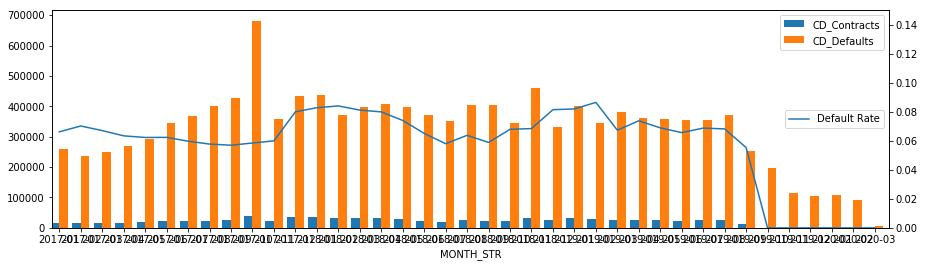

In [12]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.15)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


In [50]:
hyper_df= pd.read_csv(os.getcwd()+r"\Data Files\Hyperparameters.csv")

In [51]:
hyper_df.head()

,SCORE_NAME,TARGET,K,OBSERVATION_WINDOW,PERFORMANCE_WINDOW,DOWNSAMPLE_SIZE
0,RISK_FPD10_SCORE,RISK_FPD10,271,365,40,150000
1,RISK_FPD30_SCORE,RISK_FPD30,136,365,60,50000
2,RISK_FSPD30_SCORE,RISK_FSPD30,201,365,90,100000
3,RISK_FSTPD30_SCORE,RISK_FSTPD30,191,365,120,175000
4,RISK_FSTQPD30_SCORE,RISK_FSTQPD30,376,365,150,300000


In [78]:
df_final_test = pd.DataFrame()

import datetime
from sklearn.neighbors import KNeighborsClassifier

for x in np.arange(1,8,1):
    date_test_start = datetime.datetime(2019, x, 1)
    date_test_end = (date_test_start +  datetime.timedelta(days=31)).replace(day=1)
    df_test = df[(df["TIME_DECISION_DATE"]>=date_test_start) & 
                      (df["TIME_DECISION_DATE"]<date_test_end)]

    for y in hyper_df.index:
        score_name = hyper_df.loc[y,'SCORE_NAME']
        target = hyper_df.loc[y,'TARGET']
        K = hyper_df.loc[y,'K']
        observation_window = hyper_df.loc[y,'OBSERVATION_WINDOW']
        performance_window = hyper_df.loc[y,'PERFORMANCE_WINDOW']
        downsample_size = hyper_df.loc[y,'DOWNSAMPLE_SIZE']

        date_train_start = (date_test_start-datetime.timedelta(days=int(performance_window))-datetime.timedelta(days=int(observation_window))) 
        date_train_end = (date_test_start-datetime.timedelta(days=int(performance_window)))
        start_time = datetime.datetime.now()
        df_train = df[(df["TIME_DECISION_DATE"]>=date_train_start) & 
                  (df["TIME_DECISION_DATE"]<date_train_end)]
        
        df_class_0 = df_train[df_train[target] == 0]
        df_class_1 = df_train[df_train[target] == 1]
        df_class_0_under = df_class_0.sample(min(downsample_size,df_class_1.shape[0]))
        df_class_1_under = df_class_1.sample(min(downsample_size,df_class_1.shape[0]))
        df_train_under = pd.concat([df_class_0_under, df_class_1_under], axis=0)

        X_train = df_train_under[["CUS_LAT","CUS_LONG"]]
        X_test = df_test[["CUS_LAT","CUS_LONG"]]
        y_train = df_train_under[target]
        y_test =  df_test[target]

        knn = KNeighborsClassifier(n_neighbors = K)
        bst = knn.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))

        ypred_train = bst.predict_proba(X_train[["CUS_LAT","CUS_LONG"]])[:, 1]
        ypred_test = bst.predict_proba(X_test[["CUS_LAT","CUS_LONG"]])[:, 1]
        metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
        metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)
        gini_train = 2 * metric_auc_train - 1
        gini_test = 2 * metric_auc_test - 1

        df_test[score_name] = ypred_test
        print("Training for predicting (month):",date_test_start.month, 
              " SCORE:",score_name,
              " target:",target,
              " K:",K,
              " observation_window:",observation_window,
              " performance_window:",performance_window,
              " downsample_size:",downsample_size,
              " GINI TRAIN:",'{:,.2%}'.format(gini_train), "    GINI TEST:",'{:,.2%}'.format(gini_test),
              " time taken: ",'{:,.2}'.format((datetime.datetime.now()-start_time).seconds/60))


    if df_final_test.shape == (0,0):
        df_final_test = df_test
    else:
        df_final_test = pd.concat([df_final_test,df_test],ignore_index=True)


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 1  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 16.18%     GINI TEST: 11.98%  time taken:  1.3


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 1  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 21.52%     GINI TEST: 14.91%  time taken:  0.28


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 1  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 201  observation_window: 365  performance_window: 90  downsample_size: 100000  GINI TRAIN: 19.43%     GINI TEST: 13.64%  time taken:  0.52


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 1  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 191  observation_window: 365  performance_window: 120  downsample_size: 175000  GINI TRAIN: 18.95%     GINI TEST: 13.47%  time taken:  0.68


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 1  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observation_window: 365  performance_window: 150  downsample_size: 300000  GINI TRAIN: 15.24%     GINI TEST: 10.86%  time taken:  2.0


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 1  SCORE: RISK_FPD10_MM_SCORE  target: RISK_FPD10  K: 241  observation_window: 110  performance_window: 40  downsample_size: 50000  GINI TRAIN: 18.16%     GINI TEST: 11.07%  time taken:  0.5


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 1  SCORE: RISK_FPD30_MM_SCORE  target: RISK_FPD30  K: 66  observation_window: 90  performance_window: 60  downsample_size: 15000  GINI TRAIN: 25.49%     GINI TEST: 14.52%  time taken:  0.1


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 1  SCORE: RISK_FSPD30_MM_SCORE  target: RISK_FSPD30  K: 96  observation_window: 60  performance_window: 90  downsample_size: 20000  GINI TRAIN: 21.99%     GINI TEST: 12.27%  time taken:  0.17


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 1  SCORE: RISK_FSTPD30_MM_SCORE  target: RISK_FSTPD30  K: 206  observation_window: 30  performance_window: 120  downsample_size: 15000  GINI TRAIN: 16.59%     GINI TEST: 10.13%  time taken:  0.35


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 2  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 16.00%     GINI TEST: 11.86%  time taken:  0.8


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 2  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 22.36%     GINI TEST: 17.46%  time taken:  0.27


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 2  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 201  observation_window: 365  performance_window: 90  downsample_size: 100000  GINI TRAIN: 19.64%     GINI TEST: 15.37%  time taken:  0.48


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 2  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 191  observation_window: 365  performance_window: 120  downsample_size: 175000  GINI TRAIN: 18.77%     GINI TEST: 13.81%  time taken:  0.63


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 2  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observation_window: 365  performance_window: 150  downsample_size: 300000  GINI TRAIN: 15.03%     GINI TEST: 10.88%  time taken:  1.9


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 2  SCORE: RISK_FPD10_MM_SCORE  target: RISK_FPD10  K: 241  observation_window: 110  performance_window: 40  downsample_size: 50000  GINI TRAIN: 16.27%     GINI TEST: 11.33%  time taken:  0.43


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 2  SCORE: RISK_FPD30_MM_SCORE  target: RISK_FPD30  K: 66  observation_window: 90  performance_window: 60  downsample_size: 15000  GINI TRAIN: 24.36%     GINI TEST: 16.32%  time taken:  0.1


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 2  SCORE: RISK_FSPD30_MM_SCORE  target: RISK_FSPD30  K: 96  observation_window: 60  performance_window: 90  downsample_size: 20000  GINI TRAIN: 20.28%     GINI TEST: 11.90%  time taken:  0.15


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 2  SCORE: RISK_FSTPD30_MM_SCORE  target: RISK_FSTPD30  K: 206  observation_window: 30  performance_window: 120  downsample_size: 15000  GINI TRAIN: 16.37%     GINI TEST: 10.83%  time taken:  0.3


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 3  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 16.24%     GINI TEST: 13.37%  time taken:  0.83


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 3  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 21.64%     GINI TEST: 17.43%  time taken:  0.28


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 3  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 201  observation_window: 365  performance_window: 90  downsample_size: 100000  GINI TRAIN: 19.31%     GINI TEST: 14.83%  time taken:  0.52


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 3  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 191  observation_window: 365  performance_window: 120  downsample_size: 175000  GINI TRAIN: 18.67%     GINI TEST: 12.60%  time taken:  0.68


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 3  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observation_window: 365  performance_window: 150  downsample_size: 300000  GINI TRAIN: 15.38%     GINI TEST: 10.75%  time taken:  2.1


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 3  SCORE: RISK_FPD10_MM_SCORE  target: RISK_FPD10  K: 241  observation_window: 110  performance_window: 40  downsample_size: 50000  GINI TRAIN: 16.47%     GINI TEST: 12.68%  time taken:  0.5


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 3  SCORE: RISK_FPD30_MM_SCORE  target: RISK_FPD30  K: 66  observation_window: 90  performance_window: 60  downsample_size: 15000  GINI TRAIN: 24.94%     GINI TEST: 14.54%  time taken:  0.12


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 3  SCORE: RISK_FSPD30_MM_SCORE  target: RISK_FSPD30  K: 96  observation_window: 60  performance_window: 90  downsample_size: 20000  GINI TRAIN: 21.12%     GINI TEST: 12.12%  time taken:  0.17


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 3  SCORE: RISK_FSTPD30_MM_SCORE  target: RISK_FSTPD30  K: 206  observation_window: 30  performance_window: 120  downsample_size: 15000  GINI TRAIN: 15.24%     GINI TEST: 8.95%  time taken:  0.35


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 4  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 16.35%     GINI TEST: 13.38%  time taken:  0.87


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 4  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 21.91%     GINI TEST: 18.02%  time taken:  0.28


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 4  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 201  observation_window: 365  performance_window: 90  downsample_size: 100000  GINI TRAIN: 19.42%     GINI TEST: 15.41%  time taken:  0.62


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 4  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 191  observation_window: 365  performance_window: 120  downsample_size: 175000  GINI TRAIN: 18.32%     GINI TEST: 12.03%  time taken:  0.73


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 4  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observation_window: 365  performance_window: 150  downsample_size: 300000  GINI TRAIN: 15.09%     GINI TEST: 10.57%  time taken:  2.0


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 4  SCORE: RISK_FPD10_MM_SCORE  target: RISK_FPD10  K: 241  observation_window: 110  performance_window: 40  downsample_size: 50000  GINI TRAIN: 16.53%     GINI TEST: 12.63%  time taken:  0.45


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 4  SCORE: RISK_FPD30_MM_SCORE  target: RISK_FPD30  K: 66  observation_window: 90  performance_window: 60  downsample_size: 15000  GINI TRAIN: 24.98%     GINI TEST: 14.54%  time taken:  0.1


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 4  SCORE: RISK_FSPD30_MM_SCORE  target: RISK_FSPD30  K: 96  observation_window: 60  performance_window: 90  downsample_size: 20000  GINI TRAIN: 22.11%     GINI TEST: 12.96%  time taken:  0.15


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 4  SCORE: RISK_FSTPD30_MM_SCORE  target: RISK_FSTPD30  K: 206  observation_window: 30  performance_window: 120  downsample_size: 15000  GINI TRAIN: 16.23%     GINI TEST: 8.70%  time taken:  0.32


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 5  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 16.56%     GINI TEST: 11.51%  time taken:  0.83


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 5  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 21.93%     GINI TEST: 16.48%  time taken:  0.27


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 5  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 201  observation_window: 365  performance_window: 90  downsample_size: 100000  GINI TRAIN: 19.57%     GINI TEST: 14.63%  time taken:  0.52


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 5  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 191  observation_window: 365  performance_window: 120  downsample_size: 175000  GINI TRAIN: 18.28%     GINI TEST: 11.20%  time taken:  0.67


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 5  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observation_window: 365  performance_window: 150  downsample_size: 300000  GINI TRAIN: 15.03%     GINI TEST: 9.89%  time taken:  1.9


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 5  SCORE: RISK_FPD10_MM_SCORE  target: RISK_FPD10  K: 241  observation_window: 110  performance_window: 40  downsample_size: 50000  GINI TRAIN: 16.80%     GINI TEST: 11.35%  time taken:  0.45


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 5  SCORE: RISK_FPD30_MM_SCORE  target: RISK_FPD30  K: 66  observation_window: 90  performance_window: 60  downsample_size: 15000  GINI TRAIN: 25.50%     GINI TEST: 14.22%  time taken:  0.1


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 5  SCORE: RISK_FSPD30_MM_SCORE  target: RISK_FSPD30  K: 96  observation_window: 60  performance_window: 90  downsample_size: 20000  GINI TRAIN: 21.51%     GINI TEST: 10.63%  time taken:  0.15


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 5  SCORE: RISK_FSTPD30_MM_SCORE  target: RISK_FSTPD30  K: 206  observation_window: 30  performance_window: 120  downsample_size: 15000  GINI TRAIN: 18.00%     GINI TEST: 7.42%  time taken:  0.32


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 6  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 16.84%     GINI TEST: 10.42%  time taken:  0.82


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 6  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 21.81%     GINI TEST: 15.34%  time taken:  0.27


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 6  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 201  observation_window: 365  performance_window: 90  downsample_size: 100000  GINI TRAIN: 19.41%     GINI TEST: 12.61%  time taken:  0.5


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 6  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 191  observation_window: 365  performance_window: 120  downsample_size: 175000  GINI TRAIN: 18.50%     GINI TEST: 10.47%  time taken:  0.68


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 6  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observation_window: 365  performance_window: 150  downsample_size: 300000  GINI TRAIN: 15.27%     GINI TEST: 9.17%  time taken:  2.1


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 6  SCORE: RISK_FPD10_MM_SCORE  target: RISK_FPD10  K: 241  observation_window: 110  performance_window: 40  downsample_size: 50000  GINI TRAIN: 17.54%     GINI TEST: 10.78%  time taken:  0.5


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 6  SCORE: RISK_FPD30_MM_SCORE  target: RISK_FPD30  K: 66  observation_window: 90  performance_window: 60  downsample_size: 15000  GINI TRAIN: 26.08%     GINI TEST: 13.14%  time taken:  0.1


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 6  SCORE: RISK_FSPD30_MM_SCORE  target: RISK_FSPD30  K: 96  observation_window: 60  performance_window: 90  downsample_size: 20000  GINI TRAIN: 22.60%     GINI TEST: 10.50%  time taken:  0.17


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 6  SCORE: RISK_FSTPD30_MM_SCORE  target: RISK_FSTPD30  K: 206  observation_window: 30  performance_window: 120  downsample_size: 15000  GINI TRAIN: 17.78%     GINI TEST: 7.60%  time taken:  0.33


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 7  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 17.30%     GINI TEST: 8.64%  time taken:  0.97


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 7  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 22.89%     GINI TEST: 12.88%  time taken:  0.32


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 7  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 201  observation_window: 365  performance_window: 90  downsample_size: 100000  GINI TRAIN: 19.93%     GINI TEST: 10.08%  time taken:  0.53


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 7  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 191  observation_window: 365  performance_window: 120  downsample_size: 175000  GINI TRAIN: 18.82%     GINI TEST: 9.21%  time taken:  0.72


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 7  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observation_window: 365  performance_window: 150  downsample_size: 300000  GINI TRAIN: 15.36%     GINI TEST: 8.41%  time taken:  2.2


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 7  SCORE: RISK_FPD10_MM_SCORE  target: RISK_FPD10  K: 241  observation_window: 110  performance_window: 40  downsample_size: 50000  GINI TRAIN: 17.98%     GINI TEST: 8.19%  time taken:  0.55


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 7  SCORE: RISK_FPD30_MM_SCORE  target: RISK_FPD30  K: 66  observation_window: 90  performance_window: 60  downsample_size: 15000  GINI TRAIN: 26.79%     GINI TEST: 10.90%  time taken:  0.1


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 7  SCORE: RISK_FSPD30_MM_SCORE  target: RISK_FSPD30  K: 96  observation_window: 60  performance_window: 90  downsample_size: 20000  GINI TRAIN: 23.42%     GINI TEST: 8.12%  time taken:  0.17


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 7  SCORE: RISK_FSTPD30_MM_SCORE  target: RISK_FSTPD30  K: 206  observation_window: 30  performance_window: 120  downsample_size: 15000  GINI TRAIN: 18.63%     GINI TEST: 6.42%  time taken:  0.32


In [79]:
df_final_test.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FPD10,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,...,MONTH_STR,RISK_FPD10_SCORE,RISK_FPD30_SCORE,RISK_FSPD30_SCORE,RISK_FSTPD30_SCORE,RISK_FSTQPD30_SCORE,RISK_FPD10_MM_SCORE,RISK_FPD30_MM_SCORE,RISK_FSPD30_MM_SCORE,RISK_FSTPD30_MM_SCORE
0,220543872,2019-01-01,26.196128,73.002229,0.0,0.0,0.0,0.0,0.0,0.0,...,2019-01,0.476015,0.426471,0.437811,0.481675,0.444149,0.514523,0.393939,0.437500,0.451456
1,220543873,2019-01-01,26.280459,72.987023,0.0,0.0,0.0,0.0,0.0,0.0,...,2019-01,0.531365,0.522059,0.507463,0.492147,0.446809,0.473029,0.363636,0.562500,0.451456
2,220543874,2019-01-01,21.116755,79.104340,0.0,0.0,0.0,0.0,0.0,0.0,...,2019-01,0.450185,0.411765,0.472637,0.539267,0.457447,0.410788,0.439394,0.458333,0.514563
3,219906800,2019-01-01,18.637497,73.836025,0.0,0.0,0.0,0.0,0.0,0.0,...,2019-01,0.416974,0.257353,0.318408,0.303665,0.412234,0.390041,0.287879,0.364583,0.344660
4,219993472,2019-01-01,23.194511,77.462190,0.0,0.0,0.0,0.0,0.0,0.0,...,2019-01,0.442804,0.433824,0.477612,0.486911,0.500000,0.373444,0.333333,0.416667,0.441748


In [80]:
corr = df_final_test[[x for x in df_final_test.columns if 'SCORE' in x]].corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r' & 'BrBG' are other good diverging colormaps

,RISK_SCORE,RISK_FPD10_SCORE,RISK_FPD30_SCORE,RISK_FSPD30_SCORE,RISK_FSTPD30_SCORE,RISK_FSTQPD30_SCORE,RISK_FPD10_MM_SCORE,RISK_FPD30_MM_SCORE,RISK_FSPD30_MM_SCORE,RISK_FSTPD30_MM_SCORE
RISK_SCORE,1,0.07444,0.0519147,0.0589451,0.0661389,0.0850215,0.07436,0.0479932,0.0551837,0.0572256
RISK_FPD10_SCORE,0.07444,1,0.694239,0.719142,0.694949,0.670906,0.672602,0.488725,0.505114,0.472892
RISK_FPD30_SCORE,0.0519147,0.694239,1,0.812998,0.72376,0.561928,0.557234,0.641494,0.621737,0.545852
RISK_FSPD30_SCORE,0.0589451,0.719142,0.812998,1,0.812934,0.645855,0.534779,0.575966,0.610466,0.555293
RISK_FSTPD30_SCORE,0.0661389,0.694949,0.72376,0.812934,1,0.714341,0.474971,0.481819,0.520558,0.497436
RISK_FSTQPD30_SCORE,0.0850215,0.670906,0.561928,0.645855,0.714341,1,0.45163,0.331637,0.371435,0.370961
RISK_FPD10_MM_SCORE,0.07436,0.672602,0.557234,0.534779,0.474971,0.45163,1,0.642512,0.633742,0.591796
RISK_FPD30_MM_SCORE,0.0479932,0.488725,0.641494,0.575966,0.481819,0.331637,0.642512,1,0.717127,0.603895
RISK_FSPD30_MM_SCORE,0.0551837,0.505114,0.621737,0.610466,0.520558,0.371435,0.633742,0.717127,1,0.670025
RISK_FSTPD30_MM_SCORE,0.0572256,0.472892,0.545852,0.555293,0.497436,0.370961,0.591796,0.603895,0.670025,1


In [81]:
df_final_test.to_pickle(os.getcwd()+r"\Data Files\delinquency_scores_2019.pkl")

# EMI Payment Trend Scores

In [95]:
df1= pd.read_csv(os.getcwd()+r"\Data Files\recent_delinquency_small.csv")

In [113]:
df1["MONTH_PAY"].dt.month.value_counts()

2     723886
4     711038
6     698123
5     696816
8     692535
9     687987
7     685901
1     684146
3     683003
10    681127
11    674997
12    662698
Name: MONTH_PAY, dtype: int64

In [108]:
hyper_df= pd.read_csv(os.getcwd()+r"\Data Files\Hyperparameters_EMI_Payment_Trend.csv")

In [139]:
(date_test_start-datetime.timedelta(days=int(performance_window)-2)).replace(day=1)

datetime.datetime(2019, 2, 1, 0, 0)

In [140]:
df_final_test = pd.DataFrame()

import datetime
from sklearn.neighbors import KNeighborsClassifier

for x in np.arange(2,9,1):
    date_test_start = datetime.datetime(2019, x, 1)
    date_test_end = (date_test_start +  datetime.timedelta(days=31)).replace(day=1)
    df_test = df[(df["TIME_DECISION_DATE"]>=date_test_start) & 
                      (df["TIME_DECISION_DATE"]<date_test_end)]

    for y in hyper_df.index:
        if hyper_df.loc[y,'MONTH_HIST'] < x:
            score_name = hyper_df.loc[y,'SCORE_NAME']
            target = hyper_df.loc[y,'TARGET']
            K = hyper_df.loc[y,'K']
            observation_window = hyper_df.loc[y,'OBSERVATION_WINDOW']
            performance_window = hyper_df.loc[y,'PERFORMANCE_WINDOW']
            downsample_size = hyper_df.loc[y,'DOWNSAMPLE_SIZE']

            date_train_start = (date_test_start-datetime.timedelta(days=int(performance_window)-1)-datetime.timedelta(days=int(observation_window))).replace(day=1) 
            date_train_end = (date_test_start-datetime.timedelta(days=int(performance_window)-2)).replace(day=1)
            start_time = datetime.datetime.now()
            df_train = df1[(df1["MONTH_PAY"]>=date_train_start) & 
                      (df1["MONTH_PAY"]<date_train_end)]

            df_class_0 = df_train[df_train[target] == 0]
            df_class_1 = df_train[df_train[target] == 1]
            df_class_0_under = df_class_0.sample(min(downsample_size,df_class_1.shape[0]))
            df_class_1_under = df_class_1.sample(min(downsample_size,df_class_1.shape[0]))
            df_train_under = pd.concat([df_class_0_under, df_class_1_under], axis=0)

            X_train = df_train_under[["CUS_LAT","CUS_LONG"]]
            X_test = df_test[["CUS_LAT","CUS_LONG"]]
            y_train = df_train_under[target]
            y_test =  df_test['RISK_FSTQPD30']

            knn = KNeighborsClassifier(n_neighbors = K)
            bst = knn.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))

            ypred_train = bst.predict_proba(X_train[["CUS_LAT","CUS_LONG"]])[:, 1]
            ypred_test = bst.predict_proba(X_test[["CUS_LAT","CUS_LONG"]])[:, 1]
            metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
            metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)
            gini_train = 2 * metric_auc_train - 1
            gini_test = 2 * metric_auc_test - 1

            df_test[score_name] = ypred_test
            print("Training for predicting (month):",date_test_start.month, 
                  " SCORE:",score_name,
                  " target:",target,
                  " K:",K,
                  " observation_window:",observation_window,
                  " performance_window:",performance_window,
                  " downsample_size:",downsample_size,
                  " GINI TRAIN:",'{:,.2%}'.format(gini_train), "    GINI TEST:",'{:,.2%}'.format(gini_test),
                  " time taken: ",'{:,.2}'.format((datetime.datetime.now()-start_time).seconds/60))
        else:
            print("History not available")


    if df_final_test.shape == (0,0):
        df_final_test = df_test
    else:
        df_final_test = pd.concat([df_final_test,df_test],ignore_index=True)


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 2  SCORE: DEFAULT_FLAG_CHANGE_1  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 0  downsample_size: 80000  GINI TRAIN: 19.42%     GINI TEST: 4.16%  time taken:  0.68
History not available
History not available
History not available
History not available


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 2  SCORE: NO_PAYMENT_CURRENT_PAYMENT_1  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 0  downsample_size: 300000  GINI TRAIN: 15.70%     GINI TEST: 7.29%  time taken:  3.7
History not available
History not available
History not available
History not available


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 3  SCORE: DEFAULT_FLAG_CHANGE_1  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 0  downsample_size: 80000  GINI TRAIN: 18.97%     GINI TEST: 3.24%  time taken:  0.72


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 3  SCORE: DEFAULT_FLAG_CHANGE_2  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 30  downsample_size: 80000  GINI TRAIN: 19.67%     GINI TEST: 3.42%  time taken:  0.72
History not available
History not available
History not available


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 3  SCORE: NO_PAYMENT_CURRENT_PAYMENT_1  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 0  downsample_size: 300000  GINI TRAIN: 15.97%     GINI TEST: 7.04%  time taken:  3.8


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Training for predicting (month): 3  SCORE: NO_PAYMENT_CURRENT_PAYMENT_2  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 30  downsample_size: 300000  GINI TRAIN: 15.62%     GINI TEST: 7.46%  time taken:  3.9
History not available
History not available
History not available


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 4  SCORE: DEFAULT_FLAG_CHANGE_1  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 0  downsample_size: 80000  GINI TRAIN: 19.97%     GINI TEST: 4.04%  time taken:  0.7


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 4  SCORE: DEFAULT_FLAG_CHANGE_2  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 30  downsample_size: 80000  GINI TRAIN: 19.18%     GINI TEST: 3.51%  time taken:  0.7


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 4  SCORE: DEFAULT_FLAG_CHANGE_3  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 60  downsample_size: 80000  GINI TRAIN: 19.42%     GINI TEST: 4.77%  time taken:  0.7
History not available
History not available


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 4  SCORE: NO_PAYMENT_CURRENT_PAYMENT_1  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 0  downsample_size: 300000  GINI TRAIN: 15.98%     GINI TEST: 7.67%  time taken:  3.8


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 4  SCORE: NO_PAYMENT_CURRENT_PAYMENT_2  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 30  downsample_size: 300000  GINI TRAIN: 16.43%     GINI TEST: 6.24%  time taken:  3.8


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 4  SCORE: NO_PAYMENT_CURRENT_PAYMENT_3  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 60  downsample_size: 300000  GINI TRAIN: 15.62%     GINI TEST: 6.79%  time taken:  3.8
History not available
History not available


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 5  SCORE: DEFAULT_FLAG_CHANGE_1  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 0  downsample_size: 80000  GINI TRAIN: 19.70%     GINI TEST: 4.82%  time taken:  0.67


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 5  SCORE: DEFAULT_FLAG_CHANGE_2  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 30  downsample_size: 80000  GINI TRAIN: 20.14%     GINI TEST: 5.23%  time taken:  0.68


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 5  SCORE: DEFAULT_FLAG_CHANGE_3  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 60  downsample_size: 80000  GINI TRAIN: 18.79%     GINI TEST: 4.48%  time taken:  0.67


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 5  SCORE: DEFAULT_FLAG_CHANGE_4  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 90  downsample_size: 80000  GINI TRAIN: 19.30%     GINI TEST: 5.17%  time taken:  0.62
History not available


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 5  SCORE: NO_PAYMENT_CURRENT_PAYMENT_1  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 0  downsample_size: 300000  GINI TRAIN: 16.13%     GINI TEST: 5.69%  time taken:  1.7


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 5  SCORE: NO_PAYMENT_CURRENT_PAYMENT_2  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 30  downsample_size: 300000  GINI TRAIN: 16.10%     GINI TEST: 5.88%  time taken:  1.7


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 5  SCORE: NO_PAYMENT_CURRENT_PAYMENT_3  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 60  downsample_size: 300000  GINI TRAIN: 16.38%     GINI TEST: 4.67%  time taken:  1.7


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 5  SCORE: NO_PAYMENT_CURRENT_PAYMENT_4  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 90  downsample_size: 300000  GINI TRAIN: 15.60%     GINI TEST: 5.61%  time taken:  1.7
History not available


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 6  SCORE: DEFAULT_FLAG_CHANGE_1  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 0  downsample_size: 80000  GINI TRAIN: 22.13%     GINI TEST: 3.85%  time taken:  0.28


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 6  SCORE: DEFAULT_FLAG_CHANGE_2  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 30  downsample_size: 80000  GINI TRAIN: 19.64%     GINI TEST: 3.36%  time taken:  0.28


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 6  SCORE: DEFAULT_FLAG_CHANGE_3  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 60  downsample_size: 80000  GINI TRAIN: 20.53%     GINI TEST: 4.32%  time taken:  0.28


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 6  SCORE: DEFAULT_FLAG_CHANGE_4  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 90  downsample_size: 80000  GINI TRAIN: 18.92%     GINI TEST: 2.84%  time taken:  0.28


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 6  SCORE: DEFAULT_FLAG_CHANGE_5  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 120  downsample_size: 80000  GINI TRAIN: 19.72%     GINI TEST: 4.22%  time taken:  0.3


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 6  SCORE: NO_PAYMENT_CURRENT_PAYMENT_1  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 0  downsample_size: 300000  GINI TRAIN: 16.18%     GINI TEST: 6.26%  time taken:  1.8


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 6  SCORE: NO_PAYMENT_CURRENT_PAYMENT_2  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 30  downsample_size: 300000  GINI TRAIN: 16.14%     GINI TEST: 5.86%  time taken:  1.7


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 6  SCORE: NO_PAYMENT_CURRENT_PAYMENT_3  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 60  downsample_size: 300000  GINI TRAIN: 15.93%     GINI TEST: 5.94%  time taken:  3.3


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 6  SCORE: NO_PAYMENT_CURRENT_PAYMENT_4  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 90  downsample_size: 300000  GINI TRAIN: 16.37%     GINI TEST: 4.86%  time taken:  3.6


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 6  SCORE: NO_PAYMENT_CURRENT_PAYMENT_5  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 120  downsample_size: 300000  GINI TRAIN: 15.61%     GINI TEST: 5.52%  time taken:  4.1


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 7  SCORE: DEFAULT_FLAG_CHANGE_1  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 0  downsample_size: 80000  GINI TRAIN: 22.05%     GINI TEST: 2.90%  time taken:  0.82


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 7  SCORE: DEFAULT_FLAG_CHANGE_2  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 30  downsample_size: 80000  GINI TRAIN: 22.04%     GINI TEST: 2.96%  time taken:  0.8


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 7  SCORE: DEFAULT_FLAG_CHANGE_3  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 60  downsample_size: 80000  GINI TRAIN: 19.82%     GINI TEST: 2.86%  time taken:  0.8


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 7  SCORE: DEFAULT_FLAG_CHANGE_4  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 90  downsample_size: 80000  GINI TRAIN: 20.24%     GINI TEST: 3.56%  time taken:  0.82


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 7  SCORE: DEFAULT_FLAG_CHANGE_5  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 120  downsample_size: 80000  GINI TRAIN: 19.06%     GINI TEST: 2.59%  time taken:  0.8


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 7  SCORE: NO_PAYMENT_CURRENT_PAYMENT_1  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 0  downsample_size: 300000  GINI TRAIN: 16.76%     GINI TEST: 5.64%  time taken:  4.5


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 7  SCORE: NO_PAYMENT_CURRENT_PAYMENT_2  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 30  downsample_size: 300000  GINI TRAIN: 16.25%     GINI TEST: 5.64%  time taken:  4.4


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 7  SCORE: NO_PAYMENT_CURRENT_PAYMENT_3  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 60  downsample_size: 300000  GINI TRAIN: 16.09%     GINI TEST: 5.02%  time taken:  4.4


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 7  SCORE: NO_PAYMENT_CURRENT_PAYMENT_4  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 90  downsample_size: 300000  GINI TRAIN: 16.05%     GINI TEST: 5.62%  time taken:  4.4


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 7  SCORE: NO_PAYMENT_CURRENT_PAYMENT_5  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 120  downsample_size: 300000  GINI TRAIN: 16.37%     GINI TEST: 4.41%  time taken:  4.5


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [145]:
corr = df_final_test[[x for x in df_final_test.columns if 'DEFAULT' in x]].corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r' & 'BrBG' are other good diverging colormaps

,DEFAULT_FLAG_CHANGE_1,DEFAULT_FLAG_CHANGE_2,DEFAULT_FLAG_CHANGE_3,DEFAULT_FLAG_CHANGE_4,DEFAULT_FLAG_CHANGE_5
DEFAULT_FLAG_CHANGE_1,1,0.757449,0.740127,0.702534,0.68275
DEFAULT_FLAG_CHANGE_2,0.757449,1,0.739186,0.733455,0.700631
DEFAULT_FLAG_CHANGE_3,0.740127,0.739186,1,0.733063,0.732875
DEFAULT_FLAG_CHANGE_4,0.702534,0.733455,0.733063,1,0.748918
DEFAULT_FLAG_CHANGE_5,0.68275,0.700631,0.732875,0.748918,1


In [142]:
df_final_test.to_pickle(os.getcwd()+r"\Data Files\emi_payment_scores_2019.pkl")

In [146]:
df_final_test.head()

,CUS_LAT,CUS_LONG,DEFAULT_FLAG_CHANGE_1,DEFAULT_FLAG_CHANGE_2,DEFAULT_FLAG_CHANGE_3,DEFAULT_FLAG_CHANGE_4,DEFAULT_FLAG_CHANGE_5,GRID_ID,MONTH_STR,NO_PAYMENT_CURRENT_PAYMENT_1,...,NTC_FLAG,RISK_FPD10,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,RISK_SCORE,SKP_CREDIT_CASE,TIME_DECISION_DATE
0,30.867149,75.930356,0.455882,NaN,NaN,NaN,NaN,500_01611_05161,2019-02,0.441595,...,NTC,0.0,0.0,0.0,0.0,0.0,0.0,0.128722,223799321,2019-02-01
1,9.949001,76.322291,0.367647,NaN,NaN,NaN,NaN,500_01565_00585,2019-02,0.547009,...,Others,0.0,0.0,0.0,0.0,0.0,0.0,NaN,223801408,2019-02-01
2,22.301551,70.826877,0.426471,NaN,NaN,NaN,NaN,500_00526_03345,2019-02,0.421652,...,Others,0.0,0.0,0.0,0.0,0.0,0.0,NaN,223889993,2019-02-01
3,28.569622,77.286007,0.580882,NaN,NaN,NaN,NaN,500_01857_04652,2019-02,0.481481,...,NTC,0.0,0.0,0.0,0.0,0.0,0.0,0.202042,223889994,2019-02-01
4,23.204827,77.442296,0.389706,NaN,NaN,NaN,NaN,500_01866_03485,2019-02,0.635328,...,NTC,0.0,0.0,0.0,0.0,0.0,0.0,NaN,223889995,2019-02-01


# Generate grid based scores for selected variables

In [212]:
selected_list =['NO_PAYMENT_CURRENT_PAYMENT_1', 'DEFAULT_FLAG_CHANGE_1', 'RISK_FSTQPD30_SCORE', 'RISK_FSPD30_MM_SCORE']

In [213]:
'LOGIT_NO_PAYMENT_CURRENT_PAYMENT_1' in selected_list

False

In [317]:
hyper_df= pd.read_csv(os.getcwd()+r"\Data Files\Hyperparameters.csv")
df = pd.read_csv(os.getcwd()+r"\Data Files\final_grids.csv")
df["TIME_DECISION_DATE"]=pd.to_datetime(df["TIME_DECISION_DATE"],format = '%d-%m-%y')

In [318]:
import datetime
from sklearn.neighbors import KNeighborsClassifier

df_final_test = pd.DataFrame()

for x in np.arange(1,9,1):
    date_test_start = datetime.datetime(2019, x, 1)
    date_test_end = (date_test_start +  datetime.timedelta(days=31)).replace(day=1)
    df_test = df[(df["TIME_DECISION_DATE"]>=date_test_start) & 
                      (df["TIME_DECISION_DATE"]<date_test_end)]

    for y in hyper_df.index:
#         if hyper_df.loc[y,'SCORE_NAME'] in selected_list:
        if True:
            score_name = hyper_df.loc[y,'SCORE_NAME']
            target = hyper_df.loc[y,'TARGET']
            K = hyper_df.loc[y,'K']
            observation_window = hyper_df.loc[y,'OBSERVATION_WINDOW']
            performance_window = hyper_df.loc[y,'PERFORMANCE_WINDOW']
            downsample_size = hyper_df.loc[y,'DOWNSAMPLE_SIZE']
            fillna = hyper_df.loc[y,'FILLNA']

            date_train_start = (date_test_start-datetime.timedelta(days=int(performance_window))-datetime.timedelta(days=int(observation_window))) 
            date_train_end = (date_test_start-datetime.timedelta(days=int(performance_window)))
            start_time = datetime.datetime.now()
            df_train = df[(df["TIME_DECISION_DATE"]>=date_train_start) & 
                      (df["TIME_DECISION_DATE"]<date_train_end)]

            df_class_0 = df_train[df_train[target] == 0]
            df_class_1 = df_train[df_train[target] == 1]
            df_class_0_under = df_class_0.sample(min(downsample_size,df_class_1.shape[0]))
            df_class_1_under = df_class_1.sample(min(downsample_size,df_class_1.shape[0]))
            df_train_under = pd.concat([df_class_0_under, df_class_1_under], axis=0)

            X_train = df_train_under[["CUS_LAT","CUS_LONG"]]
            X_test = df_test[["CUS_LAT","CUS_LONG"]]
            y_train = df_train_under[target]
            y_test =  df_test[target]

            knn = KNeighborsClassifier(n_neighbors = K)
            bst = knn.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))

            ypred_train = bst.predict_proba(X_train[["CUS_LAT","CUS_LONG"]])[:, 1]
            ypred_test = bst.predict_proba(X_test[["CUS_LAT","CUS_LONG"]])[:, 1]
            metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
            metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)
            gini_train = 2 * metric_auc_train - 1
            gini_test = 2 * metric_auc_test - 1

            df_test[score_name] = ypred_test
            
            df_train_under ["G_"+score_name] = ypred_train
            grid_score = df_train_under[["GRID_ID","G_"+score_name]].groupby("GRID_ID").mean()["G_"+score_name].reset_index()
            grid_score.columns = ['GRID_ID',"G_"+score_name]
            
            df_test = pd.merge(df_test, grid_score, on = 'GRID_ID', how = 'left')
            df_test["G_"+score_name]=df_test["G_"+score_name].fillna(value = fillna)
            
            print("Training for predicting (month):",date_test_start.month, 
                  " SCORE:",score_name,
                  " target:",target,
                  " K:",K,
                  " observation_window:",observation_window,
                  " performance_window:",performance_window,
                  " downsample_size:",downsample_size,
                  " GINI TRAIN:",'{:,.2%}'.format(gini_train), "    GINI TEST:",'{:,.2%}'.format(gini_test),
                  " time taken: ",'{:,.2}'.format((datetime.datetime.now()-start_time).seconds/60))


    if df_final_test.shape == (0,0):
        df_final_test = df_test
    else:
        df_final_test = pd.concat([df_final_test,df_test],ignore_index=True)


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 1  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 16.27%     GINI TEST: 12.03%  time taken:  0.83
Training for predicting (month): 1  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 21.67%     GINI TEST: 15.14%  time taken:  0.28
Training for predicting (month): 1  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 201  observation_window: 365  performance_window: 90  downsample_size: 100000  GINI TRAIN: 19.45%     GINI TEST: 14.66%  time taken:  0.52
Training for predicting (month): 1  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 191  observation_window: 365  performance_window: 120  downsample_size: 175000  GINI TRAIN: 18.82%     GINI TEST: 13.06%  time taken:  0.67
Training for predicting (month): 1  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observa

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 2  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 16.26%     GINI TEST: 12.08%  time taken:  0.8
Training for predicting (month): 2  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 21.98%     GINI TEST: 17.80%  time taken:  0.25
Training for predicting (month): 2  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 201  observation_window: 365  performance_window: 90  downsample_size: 100000  GINI TRAIN: 19.24%     GINI TEST: 15.93%  time taken:  0.47
Training for predicting (month): 2  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 191  observation_window: 365  performance_window: 120  downsample_size: 175000  GINI TRAIN: 18.73%     GINI TEST: 13.96%  time taken:  0.62
Training for predicting (month): 2  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observat

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 3  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 16.21%     GINI TEST: 13.75%  time taken:  0.82
Training for predicting (month): 3  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 22.06%     GINI TEST: 17.95%  time taken:  0.28
Training for predicting (month): 3  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 201  observation_window: 365  performance_window: 90  downsample_size: 100000  GINI TRAIN: 19.07%     GINI TEST: 14.93%  time taken:  0.5
Training for predicting (month): 3  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 191  observation_window: 365  performance_window: 120  downsample_size: 175000  GINI TRAIN: 18.66%     GINI TEST: 12.66%  time taken:  0.63
Training for predicting (month): 3  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observat

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 4  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 16.30%     GINI TEST: 13.56%  time taken:  0.78
Training for predicting (month): 4  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 21.48%     GINI TEST: 16.90%  time taken:  0.27
Training for predicting (month): 4  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 201  observation_window: 365  performance_window: 90  downsample_size: 100000  GINI TRAIN: 19.28%     GINI TEST: 15.31%  time taken:  0.48
Training for predicting (month): 4  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 191  observation_window: 365  performance_window: 120  downsample_size: 175000  GINI TRAIN: 18.28%     GINI TEST: 12.61%  time taken:  0.63
Training for predicting (month): 4  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observa

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 5  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 16.49%     GINI TEST: 11.24%  time taken:  0.78
Training for predicting (month): 5  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 21.72%     GINI TEST: 16.23%  time taken:  0.27
Training for predicting (month): 5  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 201  observation_window: 365  performance_window: 90  downsample_size: 100000  GINI TRAIN: 19.39%     GINI TEST: 14.51%  time taken:  0.47
Training for predicting (month): 5  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 191  observation_window: 365  performance_window: 120  downsample_size: 175000  GINI TRAIN: 18.33%     GINI TEST: 11.49%  time taken:  0.62
Training for predicting (month): 5  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observa

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 6  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 17.21%     GINI TEST: 10.65%  time taken:  0.82
Training for predicting (month): 6  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 22.14%     GINI TEST: 15.17%  time taken:  0.27
Training for predicting (month): 6  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 201  observation_window: 365  performance_window: 90  downsample_size: 100000  GINI TRAIN: 19.56%     GINI TEST: 12.94%  time taken:  0.48
Training for predicting (month): 6  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 191  observation_window: 365  performance_window: 120  downsample_size: 175000  GINI TRAIN: 18.56%     GINI TEST: 10.40%  time taken:  0.65
Training for predicting (month): 6  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observa

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 7  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 17.37%     GINI TEST: 8.34%  time taken:  0.8
Training for predicting (month): 7  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 22.83%     GINI TEST: 13.21%  time taken:  0.27
Training for predicting (month): 7  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 201  observation_window: 365  performance_window: 90  downsample_size: 100000  GINI TRAIN: 20.18%     GINI TEST: 10.70%  time taken:  0.48
Training for predicting (month): 7  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 191  observation_window: 365  performance_window: 120  downsample_size: 175000  GINI TRAIN: 19.20%     GINI TEST: 8.65%  time taken:  0.63
Training for predicting (month): 7  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observatio

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 8  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 17.39%     GINI TEST: 10.64%  time taken:  0.82
Training for predicting (month): 8  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 22.43%     GINI TEST: 13.26%  time taken:  0.27
Training for predicting (month): 8  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 201  observation_window: 365  performance_window: 90  downsample_size: 100000  GINI TRAIN: 19.89%     GINI TEST: 11.97%  time taken:  0.5
Training for predicting (month): 8  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 191  observation_window: 365  performance_window: 120  downsample_size: 175000  GINI TRAIN: 19.29%     GINI TEST: 10.56%  time taken:  0.65
Training for predicting (month): 8  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observat

In [319]:
for y in hyper_df.index:
    score_name = hyper_df.loc[y,'SCORE_NAME']
    print(score_name, df_final_test[df_final_test["G_"+score_name].isna()][score_name].mean())

RISK_FPD10_SCORE nan
RISK_FPD30_SCORE nan
RISK_FSPD30_SCORE nan
RISK_FSTPD30_SCORE nan
RISK_FSTQPD30_SCORE nan
RISK_FPD10_MM_SCORE nan
RISK_FPD30_MM_SCORE nan
RISK_FSPD30_MM_SCORE nan
RISK_FSTPD30_MM_SCORE nan


In [320]:
print(2*metrics.roc_auc_score(df_final_test["RISK_FSTQPD30"],df_final_test["RISK_FSPD30_MM_SCORE"])-1)
print(2*metrics.roc_auc_score(df_final_test["RISK_FSTQPD30"],df_final_test["G_RISK_FSPD30_MM_SCORE"])-1)

print(2*metrics.roc_auc_score(df_final_test["RISK_FSTQPD30"],df_final_test["RISK_FSTQPD30_SCORE"])-1)
print(2*metrics.roc_auc_score(df_final_test["RISK_FSTQPD30"],df_final_test["G_RISK_FSTQPD30_SCORE"])-1)

0.057945135125711644
0.041860059937303795
0.10153194819088474
0.09999709435275639


In [321]:
df_final_test.to_pickle(os.getcwd()+r"\Data Files\delinquency_scores_2019.pkl")

In [322]:
df1= pd.read_csv(os.getcwd()+r"\Data Files\recent_delinquency_small.csv")

In [323]:
df1.head()

,MONTH_PAY,CUS_LAT,CUS_LONG,GRID_ID,DEFAULT_FLAG_CHANGE,NO_PAYMENT_CURRENT_PAYMENT
0,01-01-19,27.167417,78.039756,500_01998_04345,0,0
1,01-01-19,21.159421,72.798740,500_00912_03074,0,0
2,01-01-19,26.695748,75.644084,500_01529_04253,0,0
3,01-01-19,28.504803,77.242518,500_01848_04638,0,0
4,01-01-19,18.391716,73.627129,500_01053_02464,0,0


In [324]:
df1["MONTH_PAY"]= pd.to_datetime(df1["MONTH_PAY"],format = '%d-%m-%y')

In [325]:
hyper_df= pd.read_csv(os.getcwd()+r"\Data Files\Hyperparameters_EMI_Payment_Trend.csv")

In [326]:
df_final_test = pd.DataFrame()

import datetime
from sklearn.neighbors import KNeighborsClassifier

for x in np.arange(2,9,1):
    date_test_start = datetime.datetime(2019, x, 1)
    date_test_end = (date_test_start +  datetime.timedelta(days=31)).replace(day=1)
    df_test = df[(df["TIME_DECISION_DATE"]>=date_test_start) & 
                      (df["TIME_DECISION_DATE"]<date_test_end)]

    for y in hyper_df.index:
        if hyper_df.loc[y,'MONTH_HIST'] < x:
            score_name = hyper_df.loc[y,'SCORE_NAME']
            target = hyper_df.loc[y,'TARGET']
            K = hyper_df.loc[y,'K']
            observation_window = hyper_df.loc[y,'OBSERVATION_WINDOW']
            performance_window = hyper_df.loc[y,'PERFORMANCE_WINDOW']
            downsample_size = hyper_df.loc[y,'DOWNSAMPLE_SIZE']

            date_train_start = (date_test_start-datetime.timedelta(days=int(performance_window)-1)-datetime.timedelta(days=int(observation_window))).replace(day=1) 
            date_train_end = (date_test_start-datetime.timedelta(days=int(performance_window)-2)).replace(day=1)
            start_time = datetime.datetime.now()
            df_train = df1[(df1["MONTH_PAY"]>=date_train_start) & 
                      (df1["MONTH_PAY"]<date_train_end)]

            df_class_0 = df_train[df_train[target] == 0]
            df_class_1 = df_train[df_train[target] == 1]
            df_class_0_under = df_class_0.sample(min(downsample_size,df_class_1.shape[0]))
            df_class_1_under = df_class_1.sample(min(downsample_size,df_class_1.shape[0]))
            df_train_under = pd.concat([df_class_0_under, df_class_1_under], axis=0)

            X_train = df_train_under[["CUS_LAT","CUS_LONG"]]
            X_test = df_test[["CUS_LAT","CUS_LONG"]]
            y_train = df_train_under[target]
            y_test =  df_test['RISK_FSTQPD30']

            knn = KNeighborsClassifier(n_neighbors = K)
            bst = knn.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))

            ypred_train = bst.predict_proba(X_train[["CUS_LAT","CUS_LONG"]])[:, 1]
            ypred_test = bst.predict_proba(X_test[["CUS_LAT","CUS_LONG"]])[:, 1]
            metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
            metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)
            gini_train = 2 * metric_auc_train - 1
            gini_test = 2 * metric_auc_test - 1

            df_test[score_name] = ypred_test
            df_train_under ["G_"+score_name] = ypred_train
            grid_score = df_train_under[["GRID_ID","G_"+score_name]].groupby("GRID_ID").mean()["G_"+score_name].reset_index()
            grid_score.columns = ['GRID_ID',"G_"+score_name]
            
            df_test = pd.merge(df_test, grid_score, on = 'GRID_ID', how = 'left')
            df_test["G_"+score_name]=df_test["G_"+score_name].fillna(value = fillna)

            print("Training for predicting (month):",date_test_start.month, 
                  " SCORE:",score_name,
                  " target:",target,
                  " K:",K,
                  " observation_window:",observation_window,
                  " performance_window:",performance_window,
                  " downsample_size:",downsample_size,
                  " GINI TRAIN:",'{:,.2%}'.format(gini_train), "    GINI TEST:",'{:,.2%}'.format(gini_test),
                  " time taken: ",'{:,.2}'.format((datetime.datetime.now()-start_time).seconds/60))
        else:
            print("History not available")


    if df_final_test.shape == (0,0):
        df_final_test = df_test
    else:
        df_final_test = pd.concat([df_final_test,df_test],ignore_index=True)


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 2  SCORE: DEFAULT_FLAG_CHANGE_1  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 0  downsample_size: 80000  GINI TRAIN: 19.55%     GINI TEST: 3.80%  time taken:  0.28
History not available
History not available
History not available
History not available
Training for predicting (month): 2  SCORE: NO_PAYMENT_CURRENT_PAYMENT_1  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 0  downsample_size: 300000  GINI TRAIN: 15.67%     GINI TEST: 7.22%  time taken:  1.7
History not available
History not available
History not available
History not available


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 3  SCORE: DEFAULT_FLAG_CHANGE_1  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 0  downsample_size: 80000  GINI TRAIN: 18.93%     GINI TEST: 3.39%  time taken:  0.3
Training for predicting (month): 3  SCORE: DEFAULT_FLAG_CHANGE_2  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 30  downsample_size: 80000  GINI TRAIN: 19.63%     GINI TEST: 3.46%  time taken:  0.3
History not available
History not available
History not available
Training for predicting (month): 3  SCORE: NO_PAYMENT_CURRENT_PAYMENT_1  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 0  downsample_size: 300000  GINI TRAIN: 16.09%     GINI TEST: 6.81%  time taken:  1.7
Training for predicting (month): 3  SCORE: NO_PAYMENT_CURRENT_PAYMENT_2  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 30  downsample_size: 300000  GINI TRAIN: 15.67%     GINI TEST

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:72: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 4  SCORE: DEFAULT_FLAG_CHANGE_1  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 0  downsample_size: 80000  GINI TRAIN: 20.07%     GINI TEST: 4.47%  time taken:  0.28
Training for predicting (month): 4  SCORE: DEFAULT_FLAG_CHANGE_2  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 30  downsample_size: 80000  GINI TRAIN: 19.33%     GINI TEST: 3.51%  time taken:  0.28
Training for predicting (month): 4  SCORE: DEFAULT_FLAG_CHANGE_3  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 60  downsample_size: 80000  GINI TRAIN: 19.33%     GINI TEST: 4.14%  time taken:  0.28
History not available
History not available
Training for predicting (month): 4  SCORE: NO_PAYMENT_CURRENT_PAYMENT_1  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 0  downsample_size: 300000  GINI TRAIN: 15.94%     GINI TEST: 7.63%  time taken:  1.7
Training

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:72: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 5  SCORE: DEFAULT_FLAG_CHANGE_1  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 0  downsample_size: 80000  GINI TRAIN: 19.82%     GINI TEST: 4.97%  time taken:  0.28
Training for predicting (month): 5  SCORE: DEFAULT_FLAG_CHANGE_2  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 30  downsample_size: 80000  GINI TRAIN: 20.22%     GINI TEST: 4.83%  time taken:  0.28
Training for predicting (month): 5  SCORE: DEFAULT_FLAG_CHANGE_3  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 60  downsample_size: 80000  GINI TRAIN: 18.69%     GINI TEST: 4.21%  time taken:  0.28
Training for predicting (month): 5  SCORE: DEFAULT_FLAG_CHANGE_4  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 90  downsample_size: 80000  GINI TRAIN: 19.73%     GINI TEST: 5.20%  time taken:  0.28
History not available
Training for predicting (month): 5  SCORE: 

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:72: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 6  SCORE: DEFAULT_FLAG_CHANGE_1  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 0  downsample_size: 80000  GINI TRAIN: 22.07%     GINI TEST: 3.72%  time taken:  0.28
Training for predicting (month): 6  SCORE: DEFAULT_FLAG_CHANGE_2  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 30  downsample_size: 80000  GINI TRAIN: 20.16%     GINI TEST: 3.27%  time taken:  0.28
Training for predicting (month): 6  SCORE: DEFAULT_FLAG_CHANGE_3  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 60  downsample_size: 80000  GINI TRAIN: 20.09%     GINI TEST: 3.80%  time taken:  0.28
Training for predicting (month): 6  SCORE: DEFAULT_FLAG_CHANGE_4  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 90  downsample_size: 80000  GINI TRAIN: 19.02%     GINI TEST: 2.93%  time taken:  0.28
Training for predicting (month): 6  SCORE: DEFAULT_FLAG_CHANGE_5 

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:72: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 7  SCORE: DEFAULT_FLAG_CHANGE_1  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 0  downsample_size: 80000  GINI TRAIN: 22.43%     GINI TEST: 3.19%  time taken:  0.8
Training for predicting (month): 7  SCORE: DEFAULT_FLAG_CHANGE_2  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 30  downsample_size: 80000  GINI TRAIN: 22.03%     GINI TEST: 2.86%  time taken:  0.78
Training for predicting (month): 7  SCORE: DEFAULT_FLAG_CHANGE_3  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 60  downsample_size: 80000  GINI TRAIN: 19.66%     GINI TEST: 3.03%  time taken:  0.8
Training for predicting (month): 7  SCORE: DEFAULT_FLAG_CHANGE_4  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 90  downsample_size: 80000  GINI TRAIN: 19.95%     GINI TEST: 3.45%  time taken:  0.8
Training for predicting (month): 7  SCORE: DEFAULT_FLAG_CHANGE_5  ta

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:72: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 8  SCORE: DEFAULT_FLAG_CHANGE_1  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 0  downsample_size: 80000  GINI TRAIN: 21.42%     GINI TEST: 3.45%  time taken:  0.68
Training for predicting (month): 8  SCORE: DEFAULT_FLAG_CHANGE_2  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 30  downsample_size: 80000  GINI TRAIN: 22.42%     GINI TEST: 4.06%  time taken:  0.63
Training for predicting (month): 8  SCORE: DEFAULT_FLAG_CHANGE_3  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 60  downsample_size: 80000  GINI TRAIN: 22.53%     GINI TEST: 4.05%  time taken:  0.68
Training for predicting (month): 8  SCORE: DEFAULT_FLAG_CHANGE_4  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 90  downsample_size: 80000  GINI TRAIN: 19.96%     GINI TEST: 3.91%  time taken:  0.68
Training for predicting (month): 8  SCORE: DEFAULT_FLAG_CHANGE_5 

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:72: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [327]:
print(2*metrics.roc_auc_score(df_final_test["RISK_FSTQPD30"],df_final_test["DEFAULT_FLAG_CHANGE_1"])-1)
print(2*metrics.roc_auc_score(df_final_test["RISK_FSTQPD30"],df_final_test["G_DEFAULT_FLAG_CHANGE_1"])-1)

print(2*metrics.roc_auc_score(df_final_test["RISK_FSTQPD30"],df_final_test["NO_PAYMENT_CURRENT_PAYMENT_1"])-1)
print(2*metrics.roc_auc_score(df_final_test["RISK_FSTQPD30"],df_final_test["G_NO_PAYMENT_CURRENT_PAYMENT_1"])-1)

0.03837284768963167
0.024817350423631535
0.06612816477108585
0.06570630210597295


In [328]:
for y in hyper_df.index:
    score_name = hyper_df.loc[y,'SCORE_NAME']
    print(score_name, df_final_test[df_final_test["G_"+score_name].isna()][score_name].mean())

DEFAULT_FLAG_CHANGE_1 nan
DEFAULT_FLAG_CHANGE_2 nan
DEFAULT_FLAG_CHANGE_3 nan
DEFAULT_FLAG_CHANGE_4 nan
DEFAULT_FLAG_CHANGE_5 nan
NO_PAYMENT_CURRENT_PAYMENT_1 nan
NO_PAYMENT_CURRENT_PAYMENT_2 nan
NO_PAYMENT_CURRENT_PAYMENT_3 nan
NO_PAYMENT_CURRENT_PAYMENT_4 nan
NO_PAYMENT_CURRENT_PAYMENT_5 nan


In [329]:
df_final_test.to_pickle(os.getcwd()+r"\Data Files\emi_payment_scores_2019.pkl")

In [388]:
df=pd.read_pickle(os.getcwd()+r"\Data Files\delinquency_scores_2019.pkl")

In [389]:
df1= pd.read_pickle(os.getcwd()+r"\Data Files\emi_payment_scores_2019.pkl")

In [390]:
df1.columns

Index(['CUS_LAT', 'CUS_LONG', 'DEFAULT_FLAG_CHANGE_1', 'DEFAULT_FLAG_CHANGE_2',
       'DEFAULT_FLAG_CHANGE_3', 'DEFAULT_FLAG_CHANGE_4',
       'DEFAULT_FLAG_CHANGE_5', 'GRID_ID', 'G_DEFAULT_FLAG_CHANGE_1',
       'G_DEFAULT_FLAG_CHANGE_2', 'G_DEFAULT_FLAG_CHANGE_3',
       'G_DEFAULT_FLAG_CHANGE_4', 'G_DEFAULT_FLAG_CHANGE_5',
       'G_NO_PAYMENT_CURRENT_PAYMENT_1', 'G_NO_PAYMENT_CURRENT_PAYMENT_2',
       'G_NO_PAYMENT_CURRENT_PAYMENT_3', 'G_NO_PAYMENT_CURRENT_PAYMENT_4',
       'G_NO_PAYMENT_CURRENT_PAYMENT_5', 'NO_PAYMENT_CURRENT_PAYMENT_1',
       'NO_PAYMENT_CURRENT_PAYMENT_2', 'NO_PAYMENT_CURRENT_PAYMENT_3',
       'NO_PAYMENT_CURRENT_PAYMENT_4', 'NO_PAYMENT_CURRENT_PAYMENT_5',
       'NTC_FLAG', 'RISK_FPD10', 'RISK_FPD30', 'RISK_FSPD30', 'RISK_FSTPD30',
       'RISK_FSTQPD30', 'RISK_FSTQPD60', 'RISK_SCORE', 'SKP_CREDIT_CASE',
       'TIME_DECISION_DATE'],
      dtype='object')

In [391]:
df1 = df1[['NO_PAYMENT_CURRENT_PAYMENT_1', 'NO_PAYMENT_CURRENT_PAYMENT_2',
       'NO_PAYMENT_CURRENT_PAYMENT_3', 'NO_PAYMENT_CURRENT_PAYMENT_4',
       'NO_PAYMENT_CURRENT_PAYMENT_5', 'DEFAULT_FLAG_CHANGE_1', 'DEFAULT_FLAG_CHANGE_2',
       'DEFAULT_FLAG_CHANGE_3', 'DEFAULT_FLAG_CHANGE_4',
       'DEFAULT_FLAG_CHANGE_5', 'SKP_CREDIT_CASE', 'G_NO_PAYMENT_CURRENT_PAYMENT_1', 'G_NO_PAYMENT_CURRENT_PAYMENT_2',
       'G_NO_PAYMENT_CURRENT_PAYMENT_3', 'G_NO_PAYMENT_CURRENT_PAYMENT_4',
       'G_NO_PAYMENT_CURRENT_PAYMENT_5', 'G_DEFAULT_FLAG_CHANGE_1', 'G_DEFAULT_FLAG_CHANGE_2',
       'G_DEFAULT_FLAG_CHANGE_3', 'G_DEFAULT_FLAG_CHANGE_4',
       'G_DEFAULT_FLAG_CHANGE_5']]

In [392]:
df= df.merge(df1, on = 'SKP_CREDIT_CASE',how = 'right')

In [398]:
df.shape

(2523810, 51)

In [399]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FPD10,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,...,G_NO_PAYMENT_CURRENT_PAYMENT_1,G_NO_PAYMENT_CURRENT_PAYMENT_2,G_NO_PAYMENT_CURRENT_PAYMENT_3,G_NO_PAYMENT_CURRENT_PAYMENT_4,G_NO_PAYMENT_CURRENT_PAYMENT_5,G_DEFAULT_FLAG_CHANGE_1,G_DEFAULT_FLAG_CHANGE_2,G_DEFAULT_FLAG_CHANGE_3,G_DEFAULT_FLAG_CHANGE_4,G_DEFAULT_FLAG_CHANGE_5
0,223799321,2019-02-01,30.867149,75.930356,0.0,0.0,0.0,0.0,0.0,0.0,...,0.457684,NaN,NaN,NaN,NaN,0.500000,NaN,NaN,NaN,NaN
1,223801408,2019-02-01,9.949001,76.322291,0.0,0.0,0.0,0.0,0.0,0.0,...,0.538224,NaN,NaN,NaN,NaN,0.349265,NaN,NaN,NaN,NaN
2,223889993,2019-02-01,22.301551,70.826877,0.0,0.0,0.0,0.0,0.0,0.0,...,0.429592,NaN,NaN,NaN,NaN,0.391807,NaN,NaN,NaN,NaN
3,223889994,2019-02-01,28.569622,77.286007,0.0,0.0,0.0,0.0,0.0,0.0,...,0.480780,NaN,NaN,NaN,NaN,0.545168,NaN,NaN,NaN,NaN
4,223889995,2019-02-01,23.204827,77.442296,0.0,0.0,0.0,0.0,0.0,0.0,...,0.650047,NaN,NaN,NaN,NaN,0.425245,NaN,NaN,NaN,NaN


In [400]:
scores_columns= [x for x in df.columns if 'SCORE' in x]
scores_columns = scores_columns + ['NO_PAYMENT_CURRENT_PAYMENT_1', 'NO_PAYMENT_CURRENT_PAYMENT_2',
       'NO_PAYMENT_CURRENT_PAYMENT_3', 'NO_PAYMENT_CURRENT_PAYMENT_4',
       'NO_PAYMENT_CURRENT_PAYMENT_5', 'DEFAULT_FLAG_CHANGE_1', 'DEFAULT_FLAG_CHANGE_2',
       'DEFAULT_FLAG_CHANGE_3', 'DEFAULT_FLAG_CHANGE_4',
       'DEFAULT_FLAG_CHANGE_5']

In [401]:
scores_columns= ['RISK_SCORE',
 'G_RISK_FPD10_SCORE',
 'G_RISK_FPD30_SCORE',
 'G_RISK_FSPD30_SCORE',
 'G_RISK_FSTPD30_SCORE',
 'G_RISK_FSTQPD30_SCORE',
 'G_RISK_FPD10_MM_SCORE',
 'G_RISK_FPD30_MM_SCORE',
 'G_RISK_FSPD30_MM_SCORE',
 'G_RISK_FSTPD30_MM_SCORE',
 'G_NO_PAYMENT_CURRENT_PAYMENT_1',
 'G_NO_PAYMENT_CURRENT_PAYMENT_2',
 'G_DEFAULT_FLAG_CHANGE_1',
 'G_DEFAULT_FLAG_CHANGE_2']

# Convert All Scores to Logit

In [402]:
df.dropna(subset = ['RISK_SCORE'], inplace = True)
for y in scores_columns:
    df["LOGIT_"+y] = [np.log(x/(1-x)) for x in df[y]]

In [403]:
logit_columns= [x for x in df.columns if 'LOGIT' in x]

In [404]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

In [405]:
df_train = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019,3,1)) 
               & (df["TIME_DECISION_DATE"]<=datetime.datetime(2019,4,30))]
df_test = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019,5,1)) 
               & (df["TIME_DECISION_DATE"]<=datetime.datetime(2019,8,30))]

In [406]:
logit_columns=['LOGIT_G_RISK_FPD10_SCORE',
 'LOGIT_G_RISK_FPD30_SCORE',
 'LOGIT_G_RISK_FSPD30_SCORE',
 'LOGIT_G_RISK_FSTPD30_SCORE',
 'LOGIT_G_RISK_FSTQPD30_SCORE',
 'LOGIT_G_RISK_FPD10_MM_SCORE',
 'LOGIT_G_RISK_FPD30_MM_SCORE',
 'LOGIT_G_RISK_FSPD30_MM_SCORE',
 'LOGIT_G_RISK_FSTPD30_MM_SCORE',
 'LOGIT_G_NO_PAYMENT_CURRENT_PAYMENT_1',
 'LOGIT_G_NO_PAYMENT_CURRENT_PAYMENT_2',
 'LOGIT_G_DEFAULT_FLAG_CHANGE_1',
 'LOGIT_G_DEFAULT_FLAG_CHANGE_2']

# L1 and L2 logistic variable selection

In [190]:
param_grid = {'C':np.exp(np.arange(-5,5,0.001))}

In [191]:
from sklearn.model_selection import StratifiedKFold
kfolds = StratifiedKFold(3, random_state=1)
comb=LogisticRegression(penalty = 'l2')

rcv = RandomizedSearchCV(estimator = comb, param_distributions=param_grid, scoring=['roc_auc'], n_iter = 50,
    cv=kfolds.split(df_train[imp],df_train["RISK_FSTQPD30"]), verbose=0, random_state=1,
    refit = 'roc_auc', return_train_score=True, error_score = 0)

In [192]:
#Calculate Gini Lift Logistic Regression
print("Randomized search..")

search_time_start = time.time()
rcv.fit(df_train[imp],np.ravel(df_train["RISK_FSTQPD30"]))
print("Randomized search time:", time.time() - search_time_start)
params = rcv.best_params_   #get best parameters
dic=rcv.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 
tmp= pd.DataFrame(dic['params'])

Randomized search..


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Lo

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Lo

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Lo

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Lo

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Lo

Randomized search time: 93.7741391658783


In [193]:
pd.DataFrame(dic).to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\combined_model_RCV_results_FPD10.csv")

In [194]:
tmp1= pd.DataFrame(dic)[["param_C","mean_test_roc_auc","mean_train_roc_auc"]].sort_values(by = 'param_C')

In [197]:
params

{'C': 23.35941231750983}

# MOM gini of all Scores

In [372]:
df["TIME_DECISION_DATE"].min()

Timestamp('2019-02-01 00:00:00')

In [373]:
gini_mom = {'month':[],'score_column':[], 'gini':[]}
for x in df["TIME_DECISION_DATE"].dt.month.unique():
    for y in scores_columns:
        if(df[df["TIME_DECISION_DATE"].dt.month==x][y].isna().sum()>0):
            gini_mom['month'].append(x)
            gini_mom['score_column'].append(y)
            gini_mom['gini'].append(np.nan)
        else:
            gini_mom['month'].append(x)
            gini_mom['score_column'].append(y)
            gini_mom['gini'].append(2*metrics.roc_auc_score(df[df["TIME_DECISION_DATE"].dt.month==x]['RISK_FSTQPD30'],
                                       df[df["TIME_DECISION_DATE"].dt.month==x][y])-1)
        
        
#                 print(2*metrics.roc_auc_score(df[df["TIME_DECISION_DATE"].dt.month==x]['RISK_FSTQPD30'],
#                                       df[df["TIME_DECISION_DATE"].dt.month==x][y]))


In [374]:
pd.DataFrame(gini_mom).to_csv("MOM_GINI.csv")

# Use Historical Clustering to select Variables

In [356]:
scores_columns.remove('RISK_SCORE')

In [360]:
import sys
sys.path.append(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Scoring Worlflow")
from scoring import variable_clustering

clustering_correlation = variable_clustering.CorrVarClus(max_correlation=0.25,
                                                         #max_clusters=9,
                                                         standardize=True,
                                                         sample_size=50000)

clustering_correlation.fit(df_train[scores_columns], df_train['RISK_FSTQPD30'])

Sampling input dataset...
Standardazing data...
Checking data for columns with zero variance...
Calculating Gini of variables...
Calculating order of variables in clusters...
Done! Use method draw() to visualise clusters, display() to display results in a table, bestVariables() to get list of the best variables from each cluster


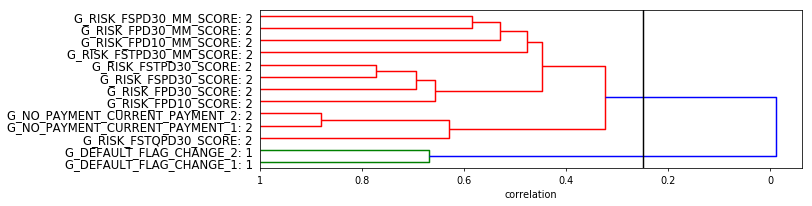

In [361]:
clustering_correlation.draw('clustering_dendrogram.png')

In [362]:
clustering_correlation.display('predictor_clusters.csv')

,Cluster,Gini,Order
G_DEFAULT_FLAG_CHANGE_2,1,-0.025830,1
G_DEFAULT_FLAG_CHANGE_1,1,-0.041818,2
G_RISK_FPD30_MM_SCORE,2,-0.028108,1
G_RISK_FSTPD30_MM_SCORE,2,-0.032120,2
G_RISK_FSPD30_MM_SCORE,2,-0.050037,3
G_RISK_FPD30_SCORE,2,-0.057898,4
G_RISK_FPD10_MM_SCORE,2,-0.060591,5
G_NO_PAYMENT_CURRENT_PAYMENT_2,2,-0.063977,6
G_RISK_FSPD30_SCORE,2,-0.073317,7
G_NO_PAYMENT_CURRENT_PAYMENT_1,2,-0.077176,8


In [96]:
selected_pred_hist = ['NO_PAYMENT_CURRENT_PAYMENT_1','RISK_FSTQPD30_SCORE','RISK_FPD10_MM_SCORE','DEFAULT_FLAG_CHANGE_2']

In [121]:
selected_logit_pred_hist = ['LOGIT_NO_PAYMENT_CURRENT_PAYMENT_1',
           'LOGIT_RISK_FSTQPD30_SCORE','LOGIT_RISK_FPD10_MM_SCORE','LOGIT_DEFAULT_FLAG_CHANGE_2']

# selected_logit_pred_hist = ['LOGIT_RISK_FSTQPD30_SCORE','DEFAULT_FLAG_CHANGE_2']


# Use L1 regularization

In [130]:
from scoring.model_selection import L1GiniModelSelection

modelL1 = L1GiniModelSelection(steps = 20,
                               grid_length=5,
                               log_C_init=-2.700,
                               max_predictors=200,
                               max_correlation=1,
                               beta_sgn_criterion=False,
                               stop_immediately=False,
                               stop_when_decr=False,
                               correlation_sample = 10000,
                               penalty='l1',
                               use_cv=True,
                               cv_folds=3,
                               cv_seed=98765)

modelL1.fit(df_train[logit_columns], df_train['RISK_FSTQPD30'],
#             sample_weight = data[train_mask][col_weight], sample_weight_valid = data[valid_mask][col_weight],
            progress_bar = True)

Cross validation will be used for the training sample.


Iteration 0   log10(C) = -2.7
{'LOGIT_RISK_FPD30_SCORE', 'LOGIT_NO_PAYMENT_CURRENT_PAYMENT_1', 'LOGIT_RISK_FPD30_MM_SCORE', 'LOGIT_DEFAULT_FLAG_CHANGE_1', 'LOGIT_RISK_FSTPD30_SCORE', 'Intercept', 'LOGIT_RISK_FSPD30_SCORE', 'LOGIT_RISK_FPD10_MM_SCORE', 'LOGIT_RISK_FSPD30_MM_SCORE', 'LOGIT_RISK_FSTQPD30_SCORE'}
Achieved Gini:  11.527281024350145
Iteration 1   log10(C) = -2.436842105263158
{'LOGIT_RISK_FPD30_SCORE', 'LOGIT_NO_PAYMENT_CURRENT_PAYMENT_1', 'LOGIT_RISK_FPD30_MM_SCORE', 'LOGIT_DEFAULT_FLAG_CHANGE_1', 'LOGIT_RISK_FSTPD30_SCORE', 'Intercept', 'LOGIT_RISK_FSPD30_SCORE', 'LOGIT_RISK_FPD10_MM_SCORE', 'LOGIT_DEFAULT_FLAG_CHANGE_2', 'LOGIT_RISK_FSPD30_MM_SCORE', 'LOGIT_RISK_FSTQPD30_SCORE', 'LOGIT_NO_PAYMENT_CURRENT_PAYMENT_2'}
Achieved Gini:  11.971719451262231
Iteration 2   log10(C) = -2.173684210526316
{'LOGIT_RISK_FPD30_SCORE', 'LOGIT_NO_PAYMENT_CURRENT_PAYMENT_1', 'LOGIT_RISK_FPD30_MM_SCORE', 'LOGIT_DEFAULT_FLAG_CHANGE_1', 'LOGIT_RISK_FSTPD30_SCORE', 'Intercept', 'LOGIT_RISK_FSP

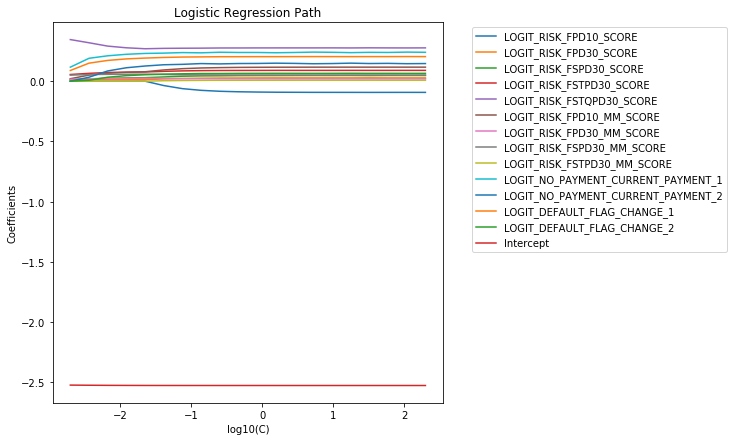

In [133]:
modelL1.draw_coeff_progression(logit_columns, 'l1path.png')

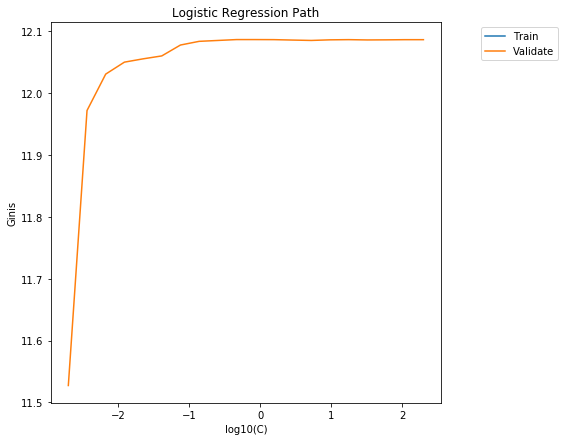

In [134]:
modelL1.draw_gini_progression('l1gini.png')

In [148]:
print('Predictors in the model:',list(modelL1.final_predictors_))

Predictors in the model: ['LOGIT_RISK_FPD30_SCORE', 'LOGIT_NO_PAYMENT_CURRENT_PAYMENT_1', 'LOGIT_RISK_FPD30_MM_SCORE', 'LOGIT_RISK_FSTPD30_MM_SCORE', 'LOGIT_DEFAULT_FLAG_CHANGE_1', 'LOGIT_RISK_FSTPD30_SCORE', 'LOGIT_RISK_FSPD30_SCORE', 'LOGIT_RISK_FPD10_MM_SCORE', 'LOGIT_DEFAULT_FLAG_CHANGE_2', 'LOGIT_RISK_FPD10_SCORE', 'LOGIT_RISK_FSPD30_MM_SCORE', 'LOGIT_RISK_FSTQPD30_SCORE', 'LOGIT_NO_PAYMENT_CURRENT_PAYMENT_2']


In [141]:
selected_logit_pred_hist = ['LOGIT_RISK_FPD30_SCORE', 'LOGIT_NO_PAYMENT_CURRENT_PAYMENT_1', 'LOGIT_RISK_FPD30_MM_SCORE', 'LOGIT_DEFAULT_FLAG_CHANGE_1', 'LOGIT_RISK_FSTPD30_SCORE', 'LOGIT_RISK_FSPD30_SCORE', 'LOGIT_RISK_FPD10_MM_SCORE', 'LOGIT_RISK_FSPD30_MM_SCORE', 'LOGIT_RISK_FSTQPD30_SCORE']


# Use XGB for variable selection

In [149]:
from scoring.metrics import gini

USE_XGBOOST = True

if USE_XGBOOST:
    import xgboost as xgb

    xgb_params = {'eta': 0.1,
      'max_depth': 3,
      'objective': 'binary:logistic',
      'eval_metric': 'auc',
      'min_child_weight': 30,
      'subsample': 0.85}

    evals_result = {}

    booster = xgb.train(params = xgb_params,
                            dtrain = xgb.DMatrix(df_train[scores_columns],df_train['RISK_FSTQPD30']),
                            num_boost_round = 500,
                            early_stopping_rounds = 50,
                            evals = ((xgb.DMatrix(df_train[scores_columns],df_train['RISK_FSTQPD30']),'train'),
                                     (xgb.DMatrix(df_test[scores_columns],df_test['RISK_FSTQPD30']),'valid')
                                    ), 
                            evals_result = evals_result,)




[12:09:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.554327	valid-auc:0.543875
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[12:09:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-auc:0.55905	valid-auc:0.546335
[12:09:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-auc:0.559777	valid-auc:0.547241
[12:09:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-auc:0.559773	valid-auc:0.547075
[12:09:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[12:09:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[83]	train-auc:0.571228	valid-auc:0.551139
[12:09:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[84]	train-auc:0.571296	valid-auc:0.551169
[12:09:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[85]	train-auc:0.571399	valid-auc:0.551184
[12:09:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[86]	train-auc:0.571438	valid-auc:0.551193
[12:09:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[87]	train-auc:0.571509	valid-auc:0.551199
[12:09:32] C:\Users\Administrato

NameError: name 'dt_xgb' is not defined

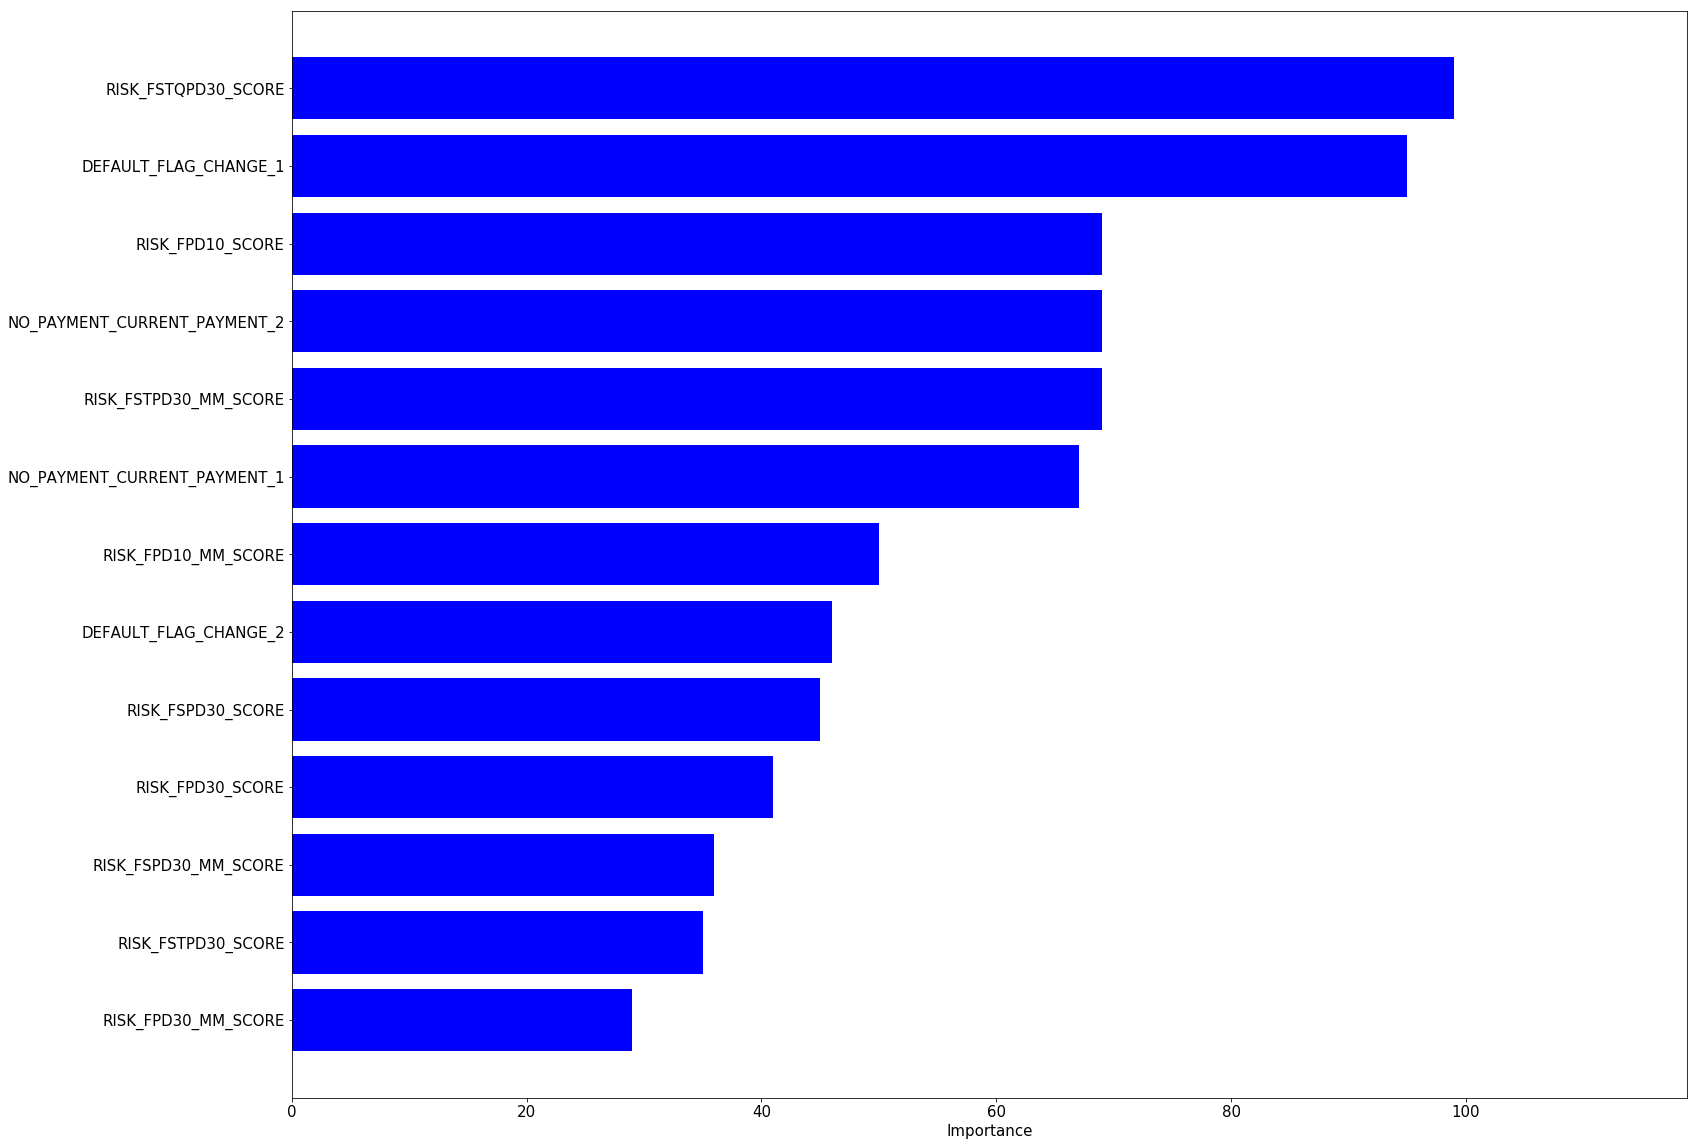

In [150]:
if USE_XGBOOST:
    %matplotlib inline
    from matplotlib import rc

    fs = booster.get_score(importance_type = 'weight')
    imp=sorted([(k, v) for k, v in fs.items()], key=lambda x:x[1], reverse = True)
    imp.reverse()

    fig=plt.figure(figsize=(25,20))
    ax=fig.add_subplot(111)
    ax.barh(range(len(imp)), [v for k, v in imp], color="blue",  align='center')
    plt.yticks(range(len(imp)), [k for k, v in imp], fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlabel('Importance',fontsize=15)
    plt.ylim([-1, len(imp)])
    plt.xlim([0, max([v for k, v in imp])*1.2])
    plt.draw()

In [153]:
imp = ['LOGIT_RISK_FSTQPD30_SCORE','LOGIT_DEFAULT_FLAG_CHANGE_1','LOGIT_RISK_FPD10_SCORE','LOGIT_NO_PAYMENT_CURRENT_PAYMENT_2']

# Use Forward Selection

In [363]:
from scoring.model_selection import GiniStepwiseLogit

modelSW = GiniStepwiseLogit(initial_predictors = set(),
                            max_iter=1000,
                            min_increase=0.1,
                            max_decrease=0.05,
                            max_predictors=0, 
                            max_correlation=0.5, 
                            beta_sgn_criterion=False, 
                            penalty='l2', C=10e10, 
                            correlation_sample=10000,
                            selection_method='stepwise',
                            use_cv=True,
                            cv_folds=3, 
                            cv_seed=98765)

modelSW.fit(df_train[logit_columns], df_train['RISK_FSTQPD30']
       # ,sample_weight = data[train_mask][col_weight], sample_weight_valid = data[valid_mask][col_weight]
       )

Cross validation will be used for the training sample.
Beta signum criterion and max correlation will not be used as the selection method is not "forward"
Iteration  0
set()
Achieved Gini:  0
Iteration  1
{'LOGIT_G_RISK_FSTQPD30_SCORE'}
Achieved Gini:  11.17017056606808
Iteration  2
{'LOGIT_G_RISK_FPD10_SCORE', 'LOGIT_G_RISK_FSTQPD30_SCORE'}
Achieved Gini:  11.375346926572789
Iteration  3
{'LOGIT_G_DEFAULT_FLAG_CHANGE_1', 'LOGIT_G_RISK_FPD10_SCORE', 'LOGIT_G_RISK_FSTQPD30_SCORE'}
Achieved Gini:  11.522884518385169
Iteration  4
{'LOGIT_G_DEFAULT_FLAG_CHANGE_1', 'LOGIT_G_RISK_FPD10_SCORE', 'LOGIT_G_RISK_FSTQPD30_SCORE'}
Achieved Gini:  11.522884518385169


GiniStepwiseLogit(C=100000000000.0, beta_sgn_criterion=False,
         correlation_sample=10000, cv_folds=3, cv_seed=98765,
         initial_predictors=set(), max_correlation=1, max_decrease=0.05,
         max_iter=1000, max_predictors=0, min_increase=0.1, penalty='l2',
         selection_method='stepwise', use_cv=True)

In [364]:
imp =['LOGIT_G_DEFAULT_FLAG_CHANGE_1', 'LOGIT_G_RISK_FPD10_SCORE', 'LOGIT_G_RISK_FSTQPD30_SCORE']

# Generate final combined Score

In [409]:
model= LogisticRegression(penalty = 'l1' , C=1)

In [410]:
model.fit(df_train[imp], df_train["RISK_FSTQPD60"])

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [411]:
pd.DataFrame({'coeff': model.coef_[0], 'logit_columns': imp})

,coeff,logit_columns
0,0.051206,LOGIT_G_DEFAULT_FLAG_CHANGE_1
1,0.138850,LOGIT_G_RISK_FPD10_SCORE
2,0.694452,LOGIT_G_RISK_FSTQPD30_SCORE


In [412]:
model.intercept_

array([-2.87712769])

In [413]:
print(2*metrics.roc_auc_score(df_test['RISK_FSTQPD30'],model.predict_proba(df_test[imp])[:,1])-1)

0.09478683088831286


In [414]:
print(2*metrics.roc_auc_score(df_test['RISK_FSTQPD30'],df_test['RISK_FSTQPD30_SCORE'])-1)

0.09399650541257754


In [415]:
len(logit_columns)

13

In [416]:
#Save Combined Score for 2nd to 8th Month

In [421]:
df1= df[df["TIME_DECISION_DATE"]>=datetime.datetime(2019,2,1)][["SKP_CREDIT_CASE","TIME_DECISION_DATE",
                                                               "CUS_LAT","CUS_LONG","GRID_ID","RISK_FSTQPD30","RISK_SCORE",
                                                              "G_DEFAULT_FLAG_CHANGE_1","DEFAULT_FLAG_CHANGE_1","LOGIT_G_DEFAULT_FLAG_CHANGE_1",
                                                              "G_RISK_FPD10_SCORE", "RISK_FPD10_SCORE","LOGIT_G_RISK_FPD10_SCORE",
                                                               "G_RISK_FSTQPD30_SCORE", "RISK_FSTQPD30_SCORE","LOGIT_G_RISK_FSTQPD30_SCORE"
                                                              ]]

In [431]:
df1["COMBINED_SCORE_KNN"] = model.predict_proba(df1[imp])[:,1]

In [432]:
df1["COMBINED_SCORE_KNN"] = 1/(1+np.exp(-(df1["LOGIT_G_DEFAULT_FLAG_CHANGE_1"]*0.051209+ 
              df1["LOGIT_G_RISK_FPD10_SCORE"]*0.139963 +
              df1["LOGIT_G_RISK_FSTQPD30_SCORE"]*0.693647 +  -2.87712769)))

In [433]:
print("GINI COMBINED: ",'{:,.2%}'.format(2 * metrics.roc_auc_score(df1["RISK_FSTQPD30"], df1["COMBINED_SCORE_KNN"]) - 1))

GINI COMBINED:  10.22%


In [2]:
import numpy as np
default_score = 1/(1+np.exp(-(np.log(0.540940336/(1-0.540940336))*0.051209+ 
              np.log(0.512941/(1-0.512941))*0.139963 +
              np.log(0.526039/(1-0.526039))*0.693647 +  -2.87712769)))

In [3]:
default_score

0.05791259110436746

In [4]:
np.log(10)

2.302585092994046

# Create combined Score with RISK Score

In [434]:
df1["LOGIT_RISK_SCORE"] = [np.log(x/(1-x)) for x in df1["RISK_SCORE"]]
df1["LOGIT_COMBINED_SCORE_KNN"] = [np.log(x/(1-x)) for x in df1["COMBINED_SCORE_KNN"]]


In [435]:
model= LogisticRegression(penalty = 'l1' , C=1)

In [439]:
model.fit(df1[df1["TIME_DECISION_DATE"]<datetime.datetime(2019,5,1)][["LOGIT_RISK_SCORE","LOGIT_COMBINED_SCORE_KNN"]], df1[df1["TIME_DECISION_DATE"]<datetime.datetime(2019,5,1)]["RISK_FSTQPD30"])

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [441]:
pd.DataFrame({'coeff': model.coef_[0], 'logit_columns': ["LOGIT_RISK_SCORE","LOGIT_COMBINED_SCORE_KNN"] })

,coeff,logit_columns
0,0.478180,LOGIT_RISK_SCORE
1,0.751557,LOGIT_COMBINED_SCORE_KNN


In [442]:
model.intercept_

array([0.80623855])

In [431]:
df1["COMBINED_SCORE"] = model.predict_proba(df1[imp])[:,1]

In [443]:
df1["COMBINED_SCORE"] = 1/(1+np.exp(-(df1["LOGIT_RISK_SCORE"]*0.47818+ 
              df1["LOGIT_COMBINED_SCORE_KNN"]*0.751557 + 0.80623855)))

In [445]:
print("GINI COMBINED: ",'{:,.2%}'.format(2 * metrics.roc_auc_score(df1["RISK_FSTQPD30"], df1["COMBINED_SCORE"]) - 1))
print("GINI COMBINED: ",'{:,.2%}'.format(2 * metrics.roc_auc_score(df1["RISK_FSTQPD30"], df1["RISK_SCORE"]) - 1))

GINI COMBINED:  26.43%
GINI COMBINED:  25.12%


In [447]:
df1.to_pickle(os.getcwd()+"\Data Files\Combined Score.pkl")